**Digit Generation - MNIST**

In [2]:
import os
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Loading Dataset

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


We are interested in generating a single digit, say 9, we will extract all images containing 9 from the train dataset.

In [4]:
digit9_images = []

for i in range(len(train_images)):
  if train_labels[i] == 9:
    digit9_images.append(train_images[i])

train_images = np.array(digit9_images)
train_images.shape  

(5949, 28, 28)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


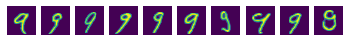

In [5]:
n = 10

f = plt.figure()

for i in range(n):
  f.add_subplot(1, n, i + 1)
  plt.subplot(1, n, i+1 ).axis("off")
  plt.imshow(train_images[i])
plt.show()

**Preparing Dataset**

In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

In [7]:
train_images = (train_images - 127.5) / 127.5

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_images.shape[0]).batch(32)

**Defining Generator Model**

In [9]:
gen_model = tf.keras.Sequential()
gen_model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
gen_model.add(tf.keras.layers.BatchNormalization())
gen_model.add(tf.keras.layers.LeakyReLU())
gen_model.add(tf.keras.layers.Reshape((7, 7, 256)))
gen_model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
gen_model.add(tf.keras.layers.BatchNormalization())
gen_model.add(tf.keras.layers.LeakyReLU())
gen_model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
gen_model.add(tf.keras.layers.BatchNormalization())
gen_model.add(tf.keras.layers.LeakyReLU())
gen_model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

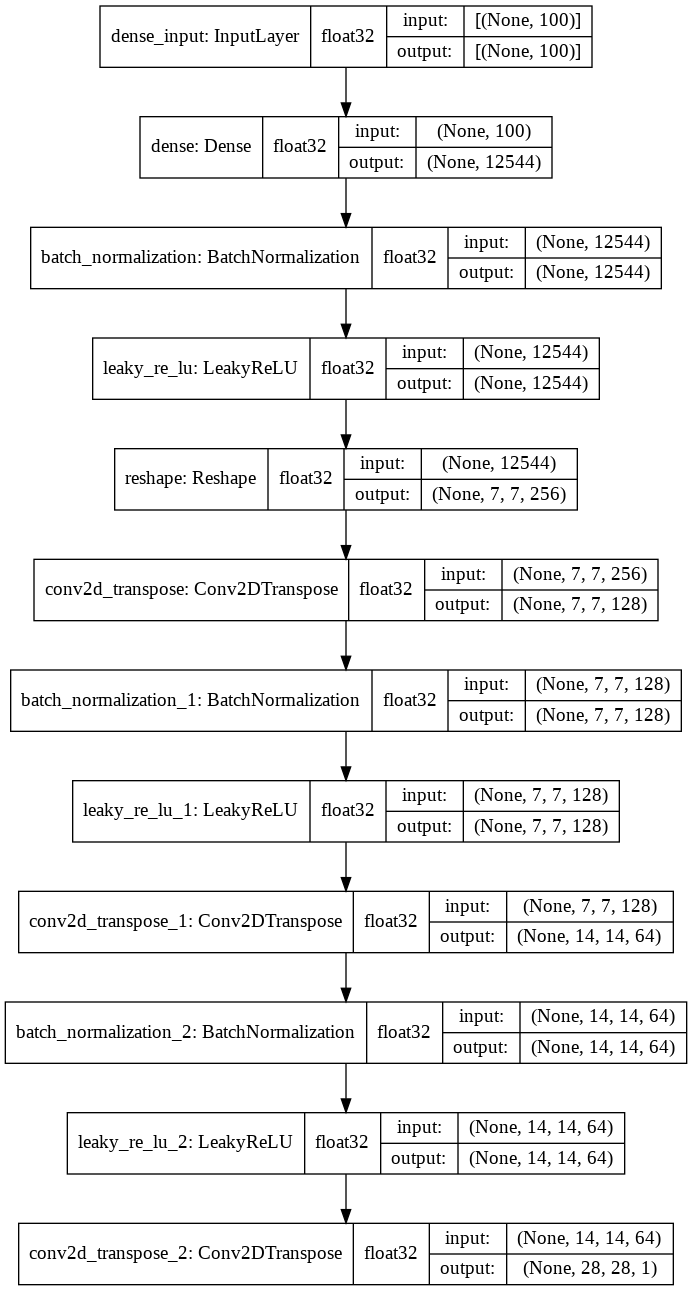

In [10]:
tf.keras.utils.plot_model(gen_model, 'generator.png', show_shapes=True, show_dtype=True, show_layer_names=True)

In [11]:
gen_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

**Testing Generator**

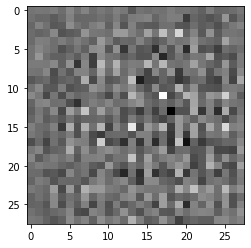

In [12]:
noise = tf.random.normal([1, 100])

#giving random input vector
generated_image = gen_model(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [13]:
generated_image.shape

TensorShape([1, 28, 28, 1])

**Defining Discriminator Model**

In [14]:
discri_model = tf.keras.Sequential()
discri_model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
discri_model.add(tf.keras.layers.LeakyReLU())
discri_model.add(tf.keras.layers.Dropout(0.3))
discri_model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discri_model.add(tf.keras.layers.LeakyReLU())
discri_model.add(tf.keras.layers.Dropout(0.3))
discri_model.add(tf.keras.layers.Flatten())
discri_model.add(tf.keras.layers.Dense(1))

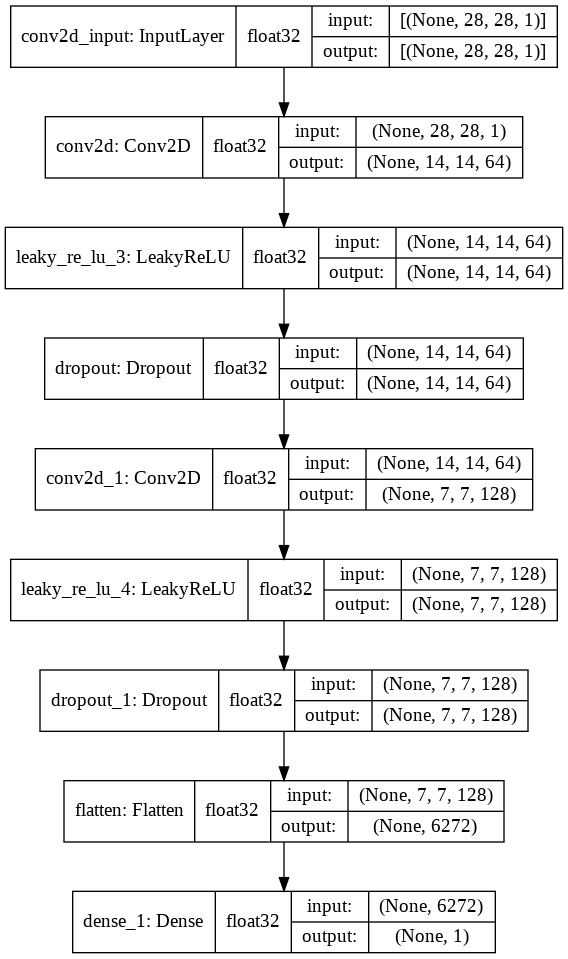

In [15]:
tf.keras.utils.plot_model(discri_model, 'discriminator.png', show_shapes=True, show_dtype=True, show_layer_names=True)

In [16]:
discri_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

**Testing Discriminator**

In [17]:
decision = discri_model(generated_image)

In [18]:
print (decision)

tf.Tensor([[-0.00105422]], shape=(1, 1), dtype=float32)


**Defining Loss Functions**

In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
def generator_loss(generated_output):
  return cross_entropy(tf.ones_like(generated_output),generated_output)

In [21]:
def discriminator_loss(real_output, generated_output):
  # compute loss considering the image is real [1,1,...,1]
  real_loss = cross_entropy(tf.ones_like(real_output),real_output)
  # compute loss considering the image is fake[0,0,...,0]
  generated_loss = cross_entropy(tf.zeros_like(generated_output), generated_output)
  # compute total loss
  total_loss = real_loss + generated_loss
  return total_loss

**Optimisers**

In [22]:
gen_optimizer = tf.optimizers.Adam(1e-4)
discri_optimizer = tf.optimizers.Adam(1e-4)

**Defining Few Functions for Training**

In [23]:
epoch_number = 0
EPOCHS = 100
noise_dim = 100
seed = tf.random.normal([1, noise_dim])

**Checkpoint Setup**

In [24]:
checkpoint_dir = '/content/drive/MyDrive/Dataset/TensorFlow_GAN_CheckPoint_Output'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

In [25]:
checkpoint = tf.train.Checkpoint(
    generator_optimizer = gen_optimizer,
    discriminator_optimizer = discri_optimizer,
    generator = gen_model,
    discriminator = discri_model
)

**Model Training Step**

In [26]:
def gradient_tuning(images):
  # create a noise vector.
  noise = tf.random.normal([16, noise_dim])

  # Use gradient tapes for automatic
  # differentiation
  with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
    # ask genertor to generate random images
    generated_images = gen_model(noise, training=True)

    # ask discriminator to evalute the real images and generate its output
    real_output = discri_model(images, training = True)
    # ask discriminator to do the evlaution on generated(fake) images
    fake_output = discri_model(generated_images, training = True)

    # calculate generator loss on fake data
    gen_loss = generator_loss(fake_output)

    # calculate discriminator loss as defined earlier
    disc_loss = discriminator_loss(real_output, fake_output)
  
    # calculate gradients for generator
    gen_gradients = generator_tape.gradient(gen_loss, gen_model.trainable_variables)

    # calculate gradients for discriminator
    discri_gradients = discriminator_tape.gradient(disc_loss, discri_model.trainable_variables)

    # use optimizer to process and apply gradients to variables
    gen_optimizer.apply_gradients(zip(gen_gradients, gen_model.trainable_variables))
    
    # same as above to discriminator
    discri_optimizer.apply_gradients(zip(discri_gradients, discri_model.trainable_variables))


In [27]:
def generate_and_save_images(model, epoch, test_input):
  global epoch_number
  epoch_number = epoch_number + 1

  # set training to false to ensure inference mode
  predictions = model(test_input, training = False)

  # display and save image
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

  plt.savefig('image_at_epoch_{:01d}.png'.format(epoch_number))
  plt.show()

**Model Training**

In [28]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      gradient_tuning(image_batch)

    # Produce images as we go
    generate_and_save_images(gen_model, epoch + 1, seed)

    # save checkpoint data
    checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format (epoch + 1, time.time()-start))

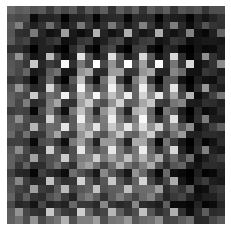

Time for epoch 1 is 8.08935832977295 sec


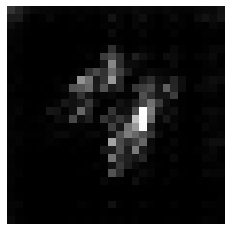

Time for epoch 2 is 7.401260852813721 sec


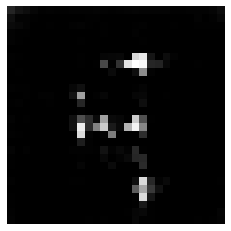

Time for epoch 3 is 7.436425447463989 sec


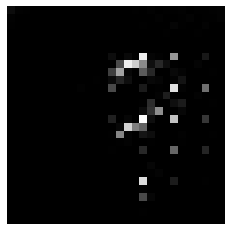

Time for epoch 4 is 7.801875114440918 sec


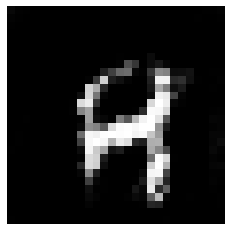

Time for epoch 5 is 7.4049131870269775 sec


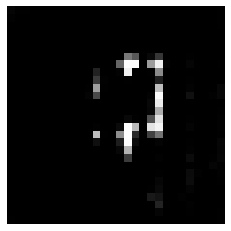

Time for epoch 6 is 7.693288564682007 sec


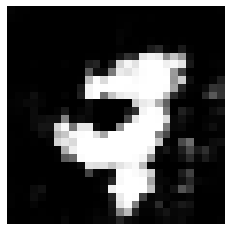

Time for epoch 7 is 7.374516725540161 sec


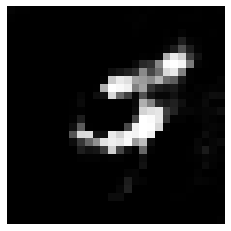

Time for epoch 8 is 7.439985752105713 sec


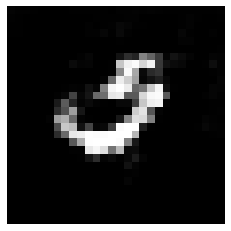

Time for epoch 9 is 7.077595949172974 sec


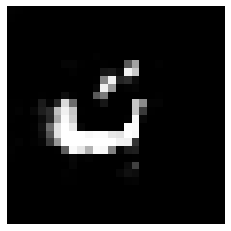

Time for epoch 10 is 7.364956855773926 sec


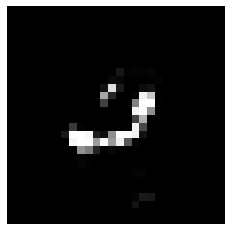

Time for epoch 11 is 7.370363473892212 sec


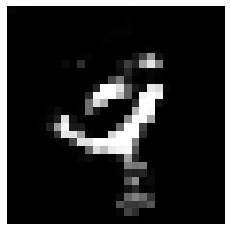

Time for epoch 12 is 7.4601967334747314 sec


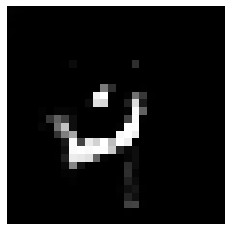

Time for epoch 13 is 7.3745293617248535 sec


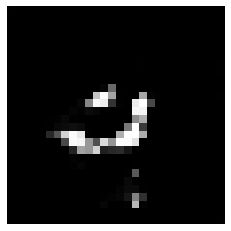

Time for epoch 14 is 7.344437837600708 sec


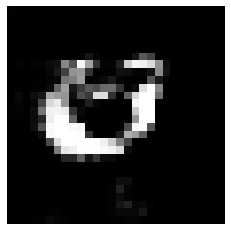

Time for epoch 15 is 7.101387023925781 sec


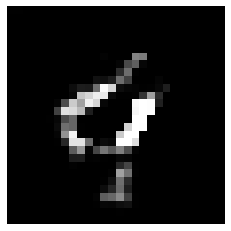

Time for epoch 16 is 7.44230580329895 sec


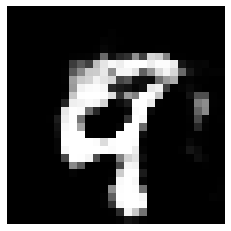

Time for epoch 17 is 7.3598949909210205 sec


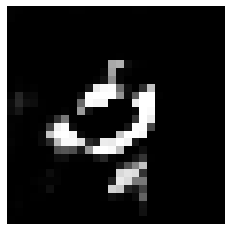

Time for epoch 18 is 7.164956569671631 sec


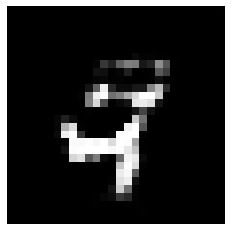

Time for epoch 19 is 7.388824224472046 sec


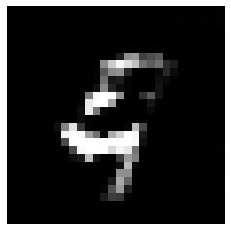

Time for epoch 20 is 7.2907280921936035 sec


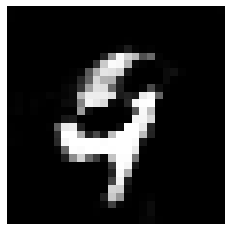

Time for epoch 21 is 7.216289043426514 sec


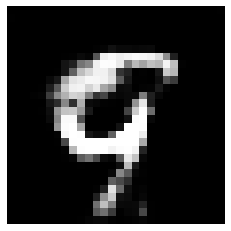

Time for epoch 22 is 7.350080251693726 sec


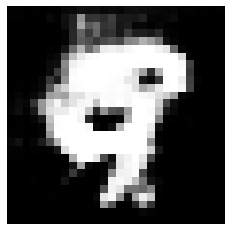

Time for epoch 23 is 7.387066602706909 sec


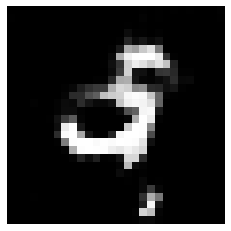

Time for epoch 24 is 7.131611347198486 sec


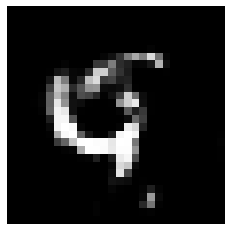

Time for epoch 25 is 7.117660045623779 sec


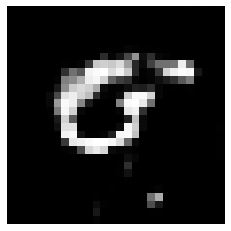

Time for epoch 26 is 7.296402454376221 sec


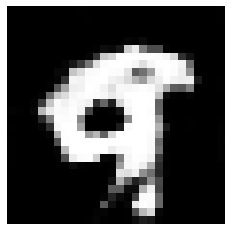

Time for epoch 27 is 6.974503755569458 sec


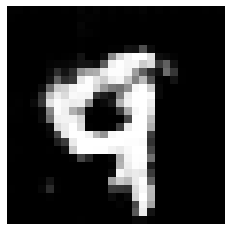

Time for epoch 28 is 7.163920640945435 sec


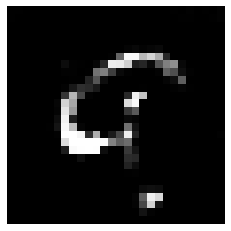

Time for epoch 29 is 7.197158098220825 sec


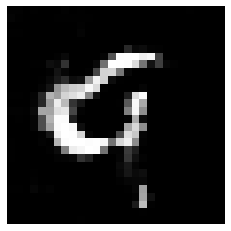

Time for epoch 30 is 7.042908191680908 sec


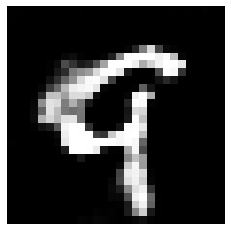

Time for epoch 31 is 7.11820912361145 sec


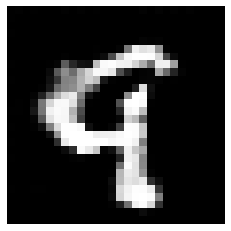

Time for epoch 32 is 7.299811124801636 sec


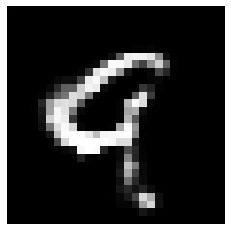

Time for epoch 33 is 6.978857755661011 sec


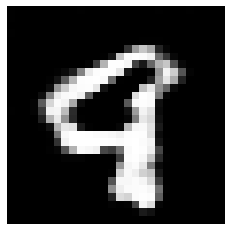

Time for epoch 34 is 7.346914529800415 sec


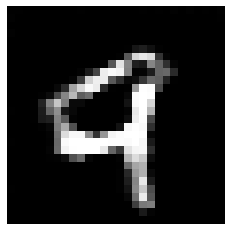

Time for epoch 35 is 7.148544549942017 sec


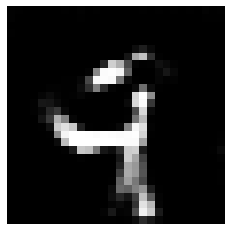

Time for epoch 36 is 7.155031442642212 sec


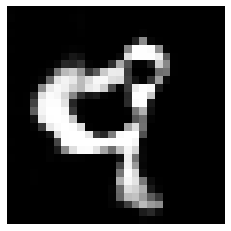

Time for epoch 37 is 10.465378284454346 sec


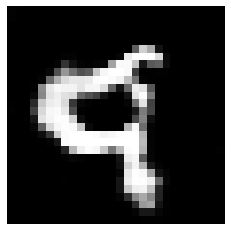

Time for epoch 38 is 7.000564813613892 sec


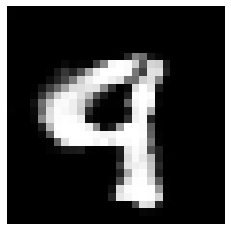

Time for epoch 39 is 7.149756908416748 sec


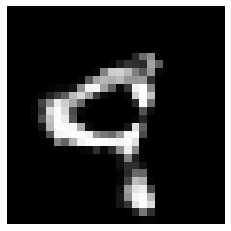

Time for epoch 40 is 7.26945161819458 sec


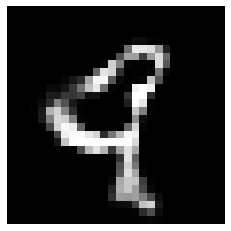

Time for epoch 41 is 7.142165422439575 sec


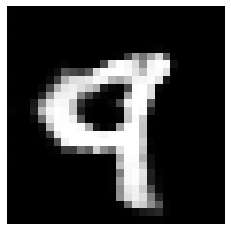

Time for epoch 42 is 7.060043811798096 sec


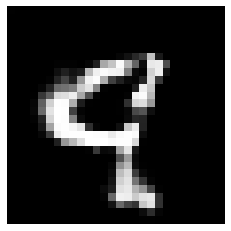

Time for epoch 43 is 7.292094945907593 sec


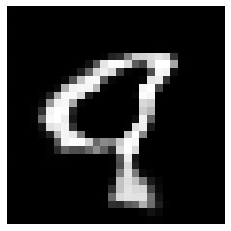

Time for epoch 44 is 7.248748302459717 sec


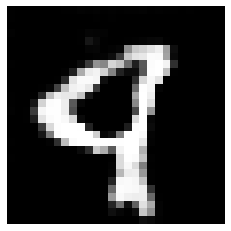

Time for epoch 45 is 7.283661842346191 sec


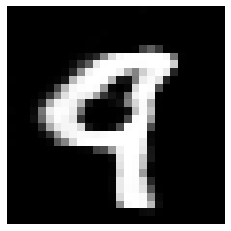

Time for epoch 46 is 7.22844934463501 sec


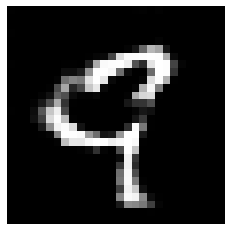

Time for epoch 47 is 7.059579849243164 sec


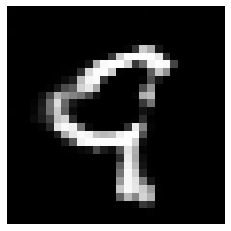

Time for epoch 48 is 7.263319730758667 sec


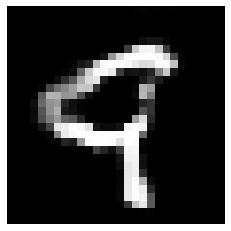

Time for epoch 49 is 7.267994165420532 sec


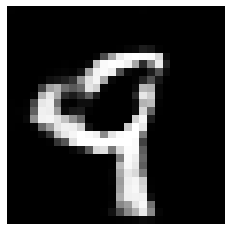

Time for epoch 50 is 7.064374923706055 sec


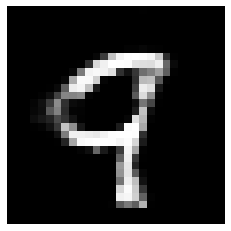

Time for epoch 51 is 7.155223369598389 sec


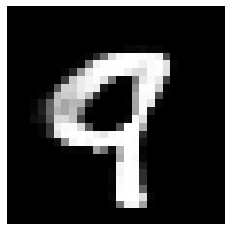

Time for epoch 52 is 7.306473255157471 sec


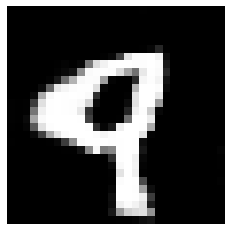

Time for epoch 53 is 7.0296313762664795 sec


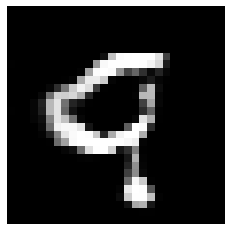

Time for epoch 54 is 7.292392015457153 sec


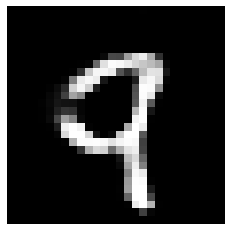

Time for epoch 55 is 7.336273431777954 sec


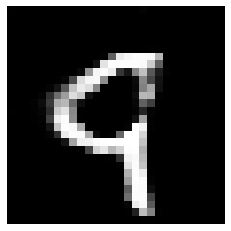

Time for epoch 56 is 7.197254657745361 sec


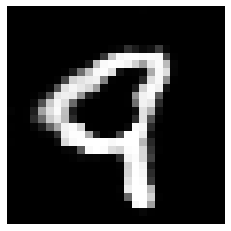

Time for epoch 57 is 7.141299486160278 sec


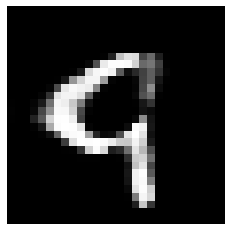

Time for epoch 58 is 7.371275901794434 sec


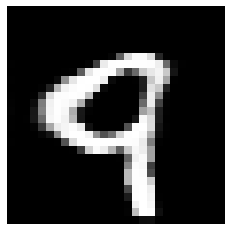

Time for epoch 59 is 6.995813608169556 sec


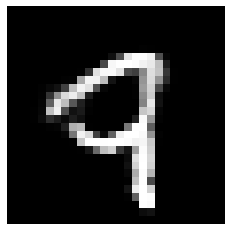

Time for epoch 60 is 7.180679559707642 sec


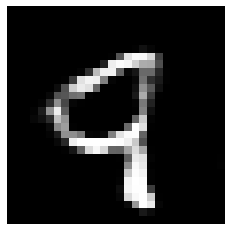

Time for epoch 61 is 7.276005268096924 sec


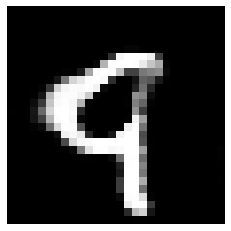

Time for epoch 62 is 7.135704517364502 sec


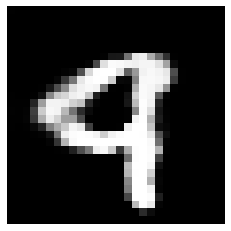

Time for epoch 63 is 7.118420839309692 sec


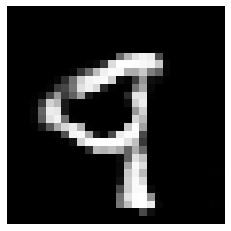

Time for epoch 64 is 7.361718416213989 sec


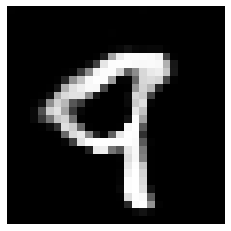

Time for epoch 65 is 7.080668926239014 sec


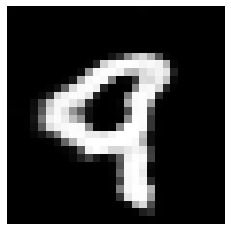

Time for epoch 66 is 7.193458557128906 sec


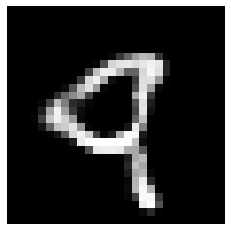

Time for epoch 67 is 7.335473299026489 sec


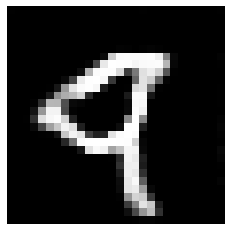

Time for epoch 68 is 7.230611562728882 sec


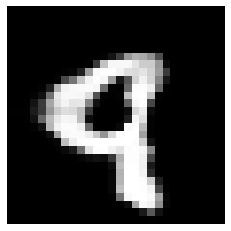

Time for epoch 69 is 7.181386709213257 sec


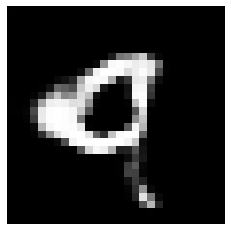

Time for epoch 70 is 7.362178802490234 sec


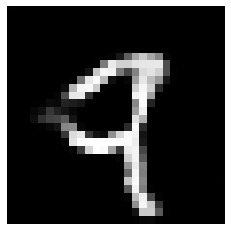

Time for epoch 71 is 7.028661251068115 sec


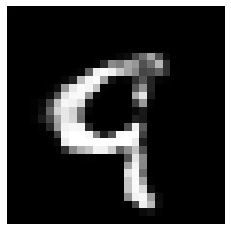

Time for epoch 72 is 7.294206380844116 sec


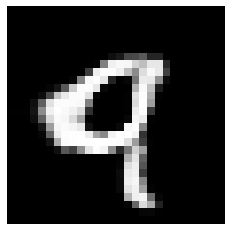

Time for epoch 73 is 7.236396551132202 sec


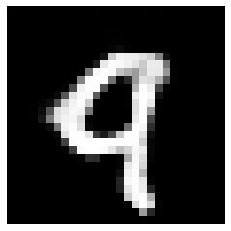

Time for epoch 74 is 7.169632911682129 sec


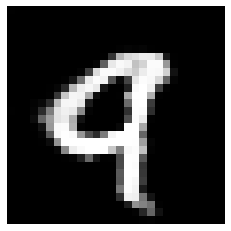

Time for epoch 75 is 10.620078325271606 sec


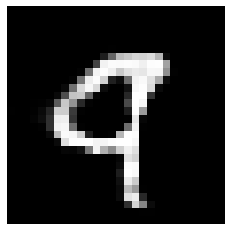

Time for epoch 76 is 7.131319999694824 sec


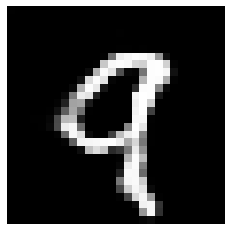

Time for epoch 77 is 7.10898756980896 sec


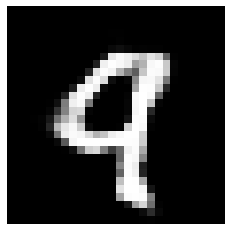

Time for epoch 78 is 7.450157403945923 sec


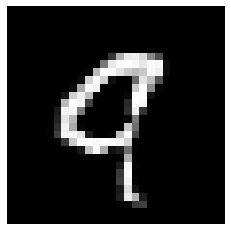

Time for epoch 79 is 7.145984888076782 sec


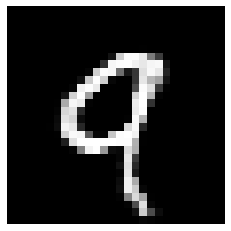

Time for epoch 80 is 7.267446041107178 sec


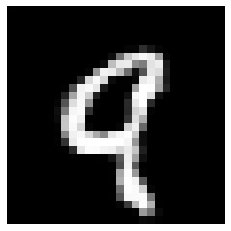

Time for epoch 81 is 7.1971375942230225 sec


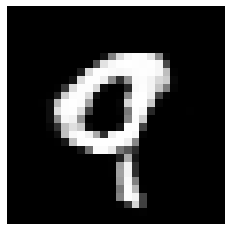

Time for epoch 82 is 7.355915069580078 sec


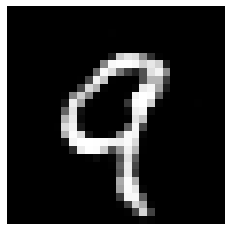

Time for epoch 83 is 7.37101411819458 sec


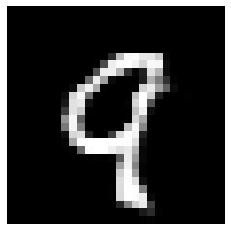

Time for epoch 84 is 7.448419809341431 sec


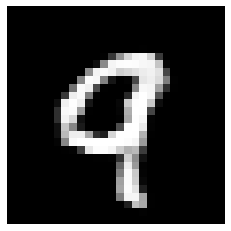

Time for epoch 85 is 7.099366188049316 sec


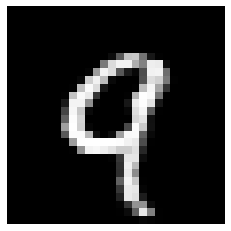

Time for epoch 86 is 7.406004428863525 sec


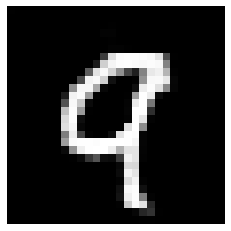

Time for epoch 87 is 7.339468002319336 sec


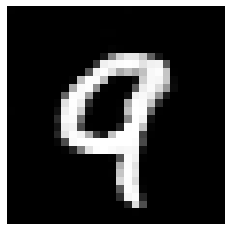

Time for epoch 88 is 7.0721964836120605 sec


In [ ]:
train(train_dataset, EPOCHS)

During training and in case of disconnection, you can restore the network state from a previous known checkpoint as shown in the statement here and continue the training.

In [ ]:
#run this code only if there is a runtime disconnection
try:
  checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
except Exception as error:
  print("Error loading in model :{}".format(error))

train(train_dataset, EPOCHS)